In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

import torch

import matplotlib.pyplot as plt
import random

from data import Sen2Dataset
from models import HFN_Default

In [2]:
BATCH_SIZE = 1
DATASET_ROOT = '/home/msiau/data/tmp/agarciat/Sentinel-2'
WEIGHTS_ROOT = 'weights'
DEVICE = 'cuda'

In [3]:
class Sen2Normalization(object):
    def __call__(self, image: torch.Tensor) -> torch.Tensor:
        return image / 10000.0

In [20]:
def visualize_image(image: torch.Tensor, patch_size: int = None):
    """Visualize image or a patch of the image"""
    image = torch.clamp(image, 0, 1)
    print(f'{image.shape=}')
    
    if patch_size:
        image = image[:, :patch_size, :patch_size]

    image = image[[2, 1, 0], :, :] if image.shape[0] >= 3 else image[0:1, :, :]
    
    
    plt.imshow(image.permute(1, 2, 0))
    plt.show()

def visualize_images_grid(images: list[torch.Tensor], patch_sizes: list[int] = None, titles: list[str] = None):
    """Visualize N images in a 1xN grid with optional titles"""
    n_images = len(images)
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 5, 5))
    
    for i, image in enumerate(images):
        image = torch.clamp(image, 0, 1)
        image = image[[2, 1, 0], :, :] if image.shape[0] >= 3 else image[0, :, :].squeeze()
        
        if patch_sizes and i < len(patch_sizes):
            patch_size = patch_sizes[i]
            image = image[:, :patch_size, :patch_size] if image.ndim == 3 else image[:patch_size, :patch_size]
        
        axes[i].imshow(image.permute(1, 2, 0) if image.ndim == 3 else image)
        axes[i].axis('off')
        
        if titles and i < len(titles):
            axes[i].set_title(titles[i])
    
    plt.show()

### Load models

In [5]:
model20 = HFN_Default(
    6,
    4
).to(DEVICE)
model20.load_state_dict(torch.load(os.path.join(WEIGHTS_ROOT, 'HFN_20.pt')))

model60 = HFN_Default(
    2,
    4+6
).to(DEVICE)
model60.load_state_dict(torch.load(os.path.join(WEIGHTS_ROOT, 'HFN_60.pt')))

/tmp/ipykernel_3033623/1810258316.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model20.load_state_dict(torch.load(os.path.join(WEIGHTS_ROOT, 'HFN_20.pt')))
/tmp/ipyke

<All keys matched successfully>

### Inference

image.shape=torch.Size([6, 288, 288])


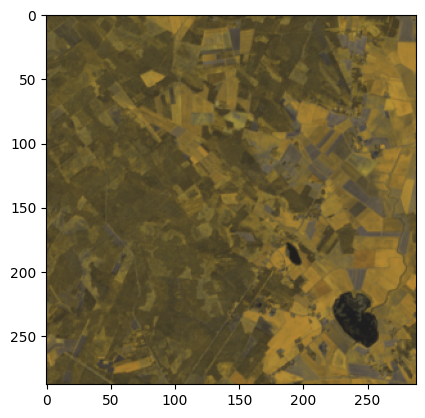

image.shape=torch.Size([6, 576, 576])


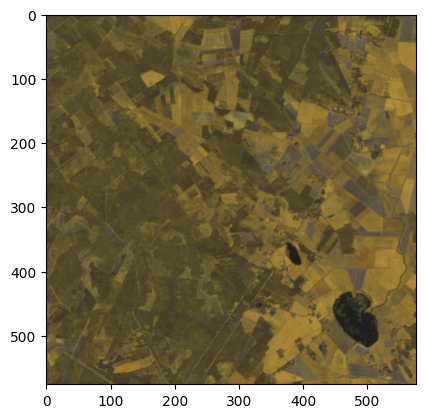

image.shape=torch.Size([2, 96, 96])


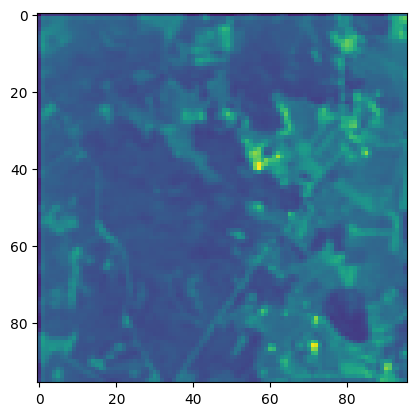

image.shape=torch.Size([2, 576, 576])


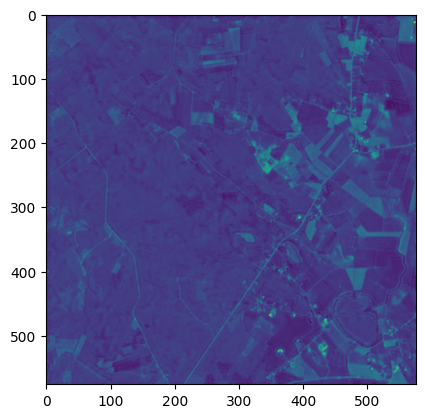

In [43]:
import cv2
with torch.no_grad():
    
    model20.eval()
    model60.eval()
    
    for set in os.listdir(DATASET_ROOT):
        set_path = os.path.join(DATASET_ROOT, set)
        processed_path = os.path.join(set_path, 'processed_data')

        rasters = list(filter(lambda x: 'raster' in x, os.listdir(set_path)))
        for raster in rasters:
            raster_path = os.path.join(set_path, raster)

            dataset = Sen2Dataset(
                raster_path,
                [10, 20, 60],
                60,
                transform=Sen2Normalization()
            )

            for x, _ in dataset:
                # 20m to 10m
                y_pred_20 = model20([x[0].unsqueeze(0).to(DEVICE), x[1].unsqueeze(0).to(DEVICE)])
                x1 = [torch.cat([x[0].to(DEVICE), y_pred_20.squeeze()], dim=0), x[2]]

                # 60m to 10m
                y_pred_60 = model60([x1[0].unsqueeze(0).to(DEVICE), x1[1].unsqueeze(0).to(DEVICE)])
                x2 = torch.cat([x1[0], y_pred_60.squeeze()], dim=0)

                name_img = f"{(len(os.listdir(processed_path))):04}.pt"

                # if random.randint(1, 50) == 50:
                #     visualize_image(x2[5:].squeeze().cpu())

                visualize_image(x[1].squeeze())
                visualize_image(x1[0][-6:].squeeze().cpu())
                visualize_image(x[2].squeeze())
                visualize_image(x2[-2:].squeeze().cpu())

                cv2.imwrite('/home/msiau/workspace/TFG-Satellite-GSSR/figures/20m_LR.png', (x[1][:3].squeeze().permute(1, 2, 0).cpu().numpy() * 255).astype(int))
                cv2.imwrite('/home/msiau/workspace/TFG-Satellite-GSSR/figures/20m_HFN.png', (x1[0][-6:-3].squeeze().permute(1, 2, 0).cpu().numpy() * 255).astype(int))
                cv2.imwrite('/home/msiau/workspace/TFG-Satellite-GSSR/figures/60m_LR.png', (x[2][:1].squeeze().cpu().numpy() * 255).astype(int))
                cv2.imwrite('/home/msiau/workspace/TFG-Satellite-GSSR/figures/60m_HFN.png', (x2[-2:-1].squeeze().cpu().numpy() * 255).astype(int))
                break
            break
        break